In [2]:
!pip install gymnasium
!pip install 'gymnasium[atari]'
!pip install 'gymnasium[accept-rom-license]'

!pip install torch torchvision torchaudio
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable

import gymnasium as gym
import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [4]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        
        self.fc1 = nn.Linear(32*4*4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [5]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        return Q(obs).argmax().detach().numpy()
    return policy_fn

In [6]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    factor = current_timestep / duration
    eps = max(eps_start + factor * (eps_end - eps_start), eps_end)
    return eps

In [7]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        if self.__len__() < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
            self.position = (self.position + 1) % self.max_size
        return 

    def sample(self, batch_size: int) -> torch.Tensor:
        rands = np.random.randint(0, self.__len__(), size = batch_size)
        obs_b = torch.stack([torch.from_numpy(self.data[i][0]) for i in rands])
        action_b = torch.stack([torch.tensor(self.data[i][1]) for i in rands ])
        reward_b = torch.stack([torch.tensor(self.data[i][2]) for i in rands])
        next_obs_b = torch.stack([torch.from_numpy(self.data[i][3]) for i in rands])
        terminated_b = torch.stack([torch.tensor(self.data[i][4]) for i in rands])
        return (obs_b, action_b, reward_b, next_obs_b, terminated_b)

In [8]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    # Calculate the TD-Target
    with torch.no_grad():
        # Double Q update
        max_action = torch.max(q(next_obs), 1)
        q_val_targ = q_target(next_obs)
        #print(f'Actions: {q1_target(next_obs)}')
        #print(f'Q Values: {max_action.indices}')
        #print(f'Q2 Values: {q2_target(next_obs)}')
        q_value = torch.gather(q_val_targ, 1, max_action.indices.unsqueeze(1)).flatten()
        #print(f'q_val_targ: {q_val_targ}')
        #print(f'Gathered Q_target Values: {q_value}')
        # print(rew)
        td_target = rew + q_value * gamma * (1-torch.Tensor(tm).float())

    
   
    #q.zero_grad()
    optimizer.zero_grad()
    
    #print(f'Actions matrix???: {act}')
    #print(f'Actions commited: {act.type(torch.int64).unsqueeze(1)}')
    #print(f'All the fucking q values: {q(obs)}')
    pred = torch.gather(q(obs), 1, act.type(torch.int64).unsqueeze(1)).flatten()
    #print(f'The fucking prediction filtered by the actual action taken: {pred}')
    loss_fun = nn.MSELoss()
    loss = loss_fun(td_target, pred)
    loss.backward()
    optimizer.step()
    

In [9]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    # TODO: Calculate the TD-Target
    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    loss = F.mse_loss(q(obs).gather(1, act.type(torch.int64).unsqueeze(1)), td_target.unsqueeze(1))

    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()


In [10]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    for param, target_param in zip(params, target_params):
        target_param.data.mul_(1 - tau)
        target_param.data.add_(param.data * tau)

<h1>DQN</h1>

In [11]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            tau = 0.005
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.tau = tau

        self.buffer = ReplayBuffer(maxlen)

        self.q = DQN(env.observation_space.shape, env.action_space.n)

        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        self.optimizer = optim.Adam(self.q.parameters(), lr = lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  Transitions: {len(self.buffer)}')
            
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                   
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                    
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(obs, action, reward, next_obs, terminated)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch.float(),
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )
                #if current_timestep % self.update_freq == 0:
                    #self.q1_target.load_state_dict(copy.deepcopy(self.q1.state_dict()))
                    #self.q2_target.load_state_dict(copy.deepcopy(self.q2.state_dict()))
                polyak_update(self.q.parameters(), self.q_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

<h1>DDQN</h1>

In [12]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            tau = 0.005
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.tau = tau

        self.buffer = ReplayBuffer(maxlen)

        self.q = DQN(env.observation_space.shape, env.action_space.n)

        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        self.optimizer = optim.Adam(self.q.parameters(), lr = lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start
        
        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  Transitions: {len(self.buffer)}')
            
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                   
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                    
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(obs, action, reward, next_obs, terminated)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Q network
                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch.float(),
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )
                #if current_timestep % self.update_freq == 0:
                    #self.q1_target.load_state_dict(copy.deepcopy(self.q1.state_dict()))
                    #self.q2_target.load_state_dict(copy.deepcopy(self.q2.state_dict()))
                polyak_update(self.q.parameters(), self.q_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [21]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit

LR = 0.001
BATCH_SIZE = 16
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 100_000
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
TAU = 0.005

# Even though I played around with the hyperparameters I was not able to achieve a better result than
# the original set.

# Train DDQN
agent = DDQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU
)
stats1 = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 100 of 1000  Time Step: 6294  Epsilon: 0.472  Transitions: 6294
Episode 200 of 1000  Time Step: 16244  Epsilon: 0.427  Transitions: 16244
Episode 300 of 1000  Time Step: 26547  Epsilon: 0.381  Transitions: 26547
Episode 400 of 1000  Time Step: 37873  Epsilon: 0.330  Transitions: 37873
Episode 500 of 1000  Time Step: 49045  Epsilon: 0.279  Transitions: 49045
Episode 600 of 1000  Time Step: 62454  Epsilon: 0.219  Transitions: 62454
Episode 700 of 1000  Time Step: 76932  Epsilon: 0.154  Transitions: 76932
Episode 800 of 1000  Time Step: 93964  Epsilon: 0.077  Transitions: 93964
Episode 900 of 1000  Time Step: 115000  Epsilon: 0.050  Transitions: 100000
Episode 1000 of 1000  Time Step: 137334  Epsilon: 0.050  Transitions: 100000


In [22]:
#Train DQN
agent_dqn = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    tau = TAU
)
stats2 = agent_dqn.train(NUM_EPISODES)

Episode 100 of 1000  Time Step: 5400  Epsilon: 0.476  Transitions: 5400
Episode 200 of 1000  Time Step: 14189  Epsilon: 0.436  Transitions: 14189
Episode 300 of 1000  Time Step: 24450  Epsilon: 0.390  Transitions: 24450
Episode 400 of 1000  Time Step: 35107  Epsilon: 0.342  Transitions: 35107
Episode 500 of 1000  Time Step: 47141  Epsilon: 0.288  Transitions: 47141
Episode 600 of 1000  Time Step: 59800  Epsilon: 0.231  Transitions: 59800
Episode 700 of 1000  Time Step: 72510  Epsilon: 0.174  Transitions: 72510
Episode 800 of 1000  Time Step: 87362  Epsilon: 0.107  Transitions: 87362
Episode 900 of 1000  Time Step: 106286  Epsilon: 0.050  Transitions: 100000
Episode 1000 of 1000  Time Step: 125777  Epsilon: 0.050  Transitions: 100000


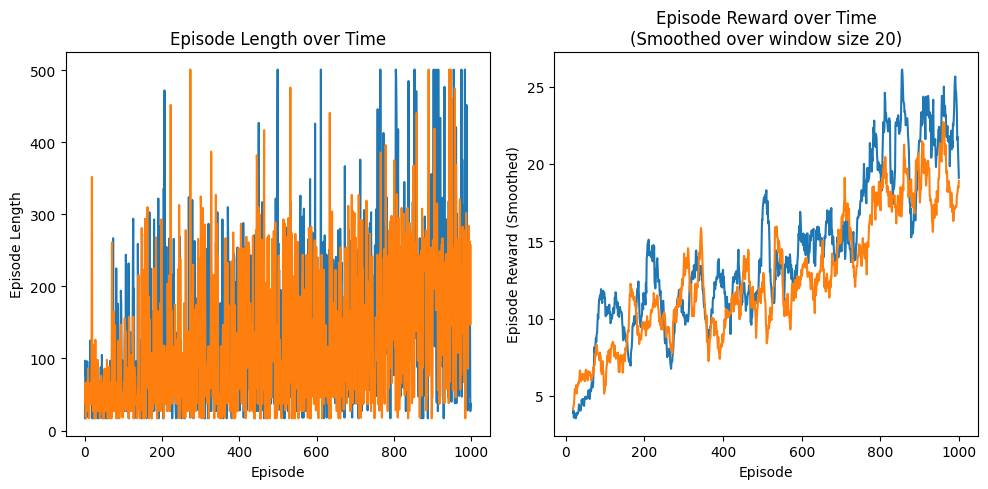

In [23]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats1.episode_lengths)
ax.plot(stats2.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed1 = pd.Series(stats1.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed2 = pd.Series(stats2.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed1)
ax.plot(rewards_smoothed2)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()


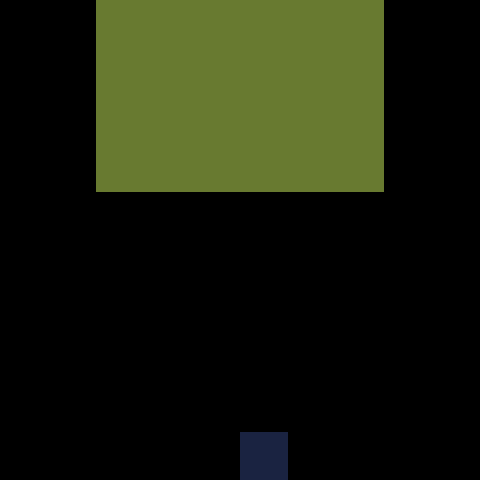

In [25]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")